In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import astropy.units as u

from sklearn.neighbors import KernelDensity

/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=2.725)

In [3]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 35 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

[ 1.21154796e-05  4.39319909e-04 -2.11420409e-02  1.77834331e-01]


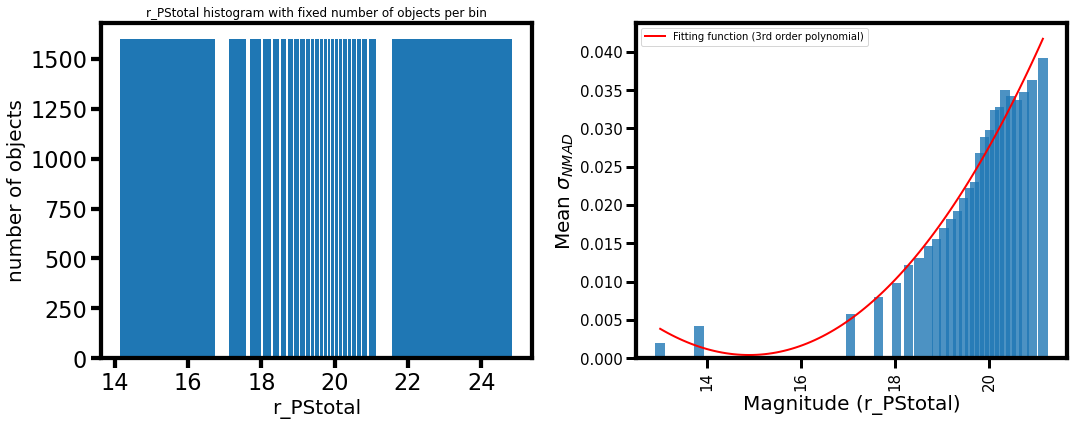

In [4]:
from galaxy_cluster_membership import *

### Load cluster data

In [5]:
cl_radius_deg = 1.5744 #Virial radius of Hydra (in degrees)
cl_ra = 159.17 #RA of the center of Hydra (in degrees)
cl_dec = -27.524 #DEC of the center of Hydra (in degrees)
cl_z = 0.012 #redshift of Hydra

cl_name = "Hydra Cluster"

In [6]:
t = pd.read_csv("../../Masters/Pesquisa/CHANCES-target-selection/CHANCES-catalogues/final_catalogue_tables/Hydra-InSPLUS-AndLegacy-CHANCES_new_modified.csv", 
                usecols=['OBJECT_ID', 'RA_J2000', 'Dec_J2000', 'zp', 'RFIBER', 'RMAG', 'EB_V', "G_R", "pdf_means", "pdf_stds", "pdf_weights"])

In [57]:
objid = np.array(t["OBJECT_ID"])
ra = np.array(t["RA_J2000"])
dec = np.array(t["Dec_J2000"])
zp = np.array(t["zp"])
rmag = np.array(t["RMAG"])

pdf_means = np.array([[float(_) for _ in t["pdf_means"][i].split(',')] for i in range(len(t))])
pdf_stds = np.array([[float(_) for _ in t["pdf_stds"][i].split(',')] for i in range(len(t))])
pdf_weights = np.array([[float(_) for _ in t["pdf_weights"][i].split(',')] for i in range(len(t))])

### Membership

In [8]:
dist = clustercentric_distance(ra, dec, cl_ra, cl_dec)

In [50]:
#Aqui eu estou usando o RMAG porque é uma comparação direta ao que a gente fez no CHANCES
sigma_z = np.array([sigma_nmad_(r) for r in rmag])

#Define the volume of the cluster
#fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
fz1 = 3.5
fz2 = fz1
fr = 5.0

#This mask defines all galaxies in the fr*R200 projected area of the cluster and also imposes a magnitude limit to the galaxies
mask_cluster_region = (dist < fr*cl_radius_deg) & (rmag < 21)

#This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
mask_cluster = mask_cluster_region & (zp > cl_z - fz1*sigma_z*(1+cl_z)) & (zp < cl_z + fz1*sigma_z*(1+cl_z))

In [51]:
z_bins = 50
bw = (zp[mask_cluster].max() - zp[mask_cluster].min()) / z_bins

kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(zp[mask_cluster][:, np.newaxis])
zz_phot = np.linspace(zp[mask_cluster].min(), zp[mask_cluster].max(), len(zp[mask_cluster]))[:, np.newaxis]
log_dens_zz_phot = kde.score_samples(zz_phot)

zp_peak = zz_phot[np.argmax(np.exp(log_dens_zz_phot))]
zp_bias = zp_peak - cl_z

zp_unbiased = zp - zp_bias

mask_cluster_unbiased = mask_cluster_region & (zp_unbiased > cl_z - 
                    fz1*sigma_z*(1+cl_z)) & (zp_unbiased < cl_z + fz1*sigma_z*(1+cl_z))

print("zp_bias = {}".format(zp_bias))

zp_bias = [0.06907781]


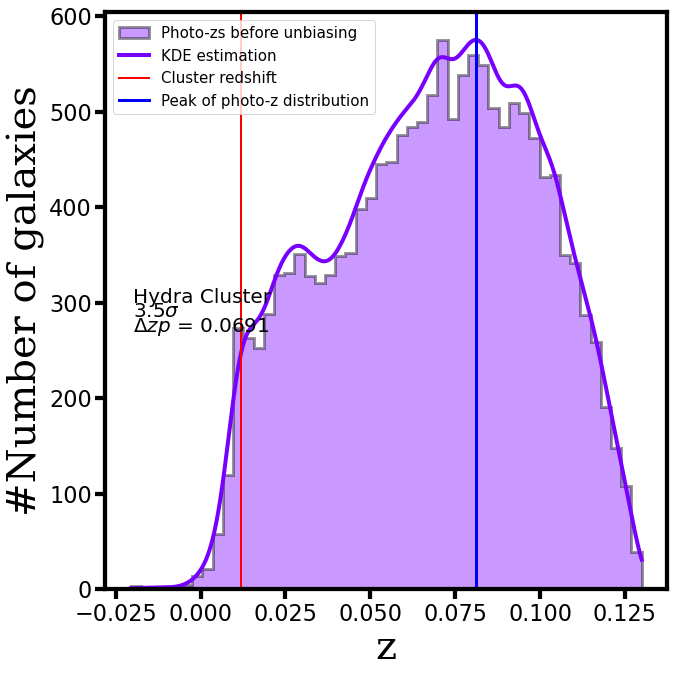

In [54]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

pz_hist = ax1.hist(zp[mask_cluster], bins=50, color=colors3[3], histtype='stepfilled', edgecolor='k', linewidth=3.0,
        range=[zp[mask_cluster].min(), zp[mask_cluster].max()], alpha=0.4, label="Photo-zs before unbiasing")[0]

# ax1.hist(z_specz_members, bins=50, color=colors1[3], histtype='stepfilled', edgecolor='k', alpha=0.5, linewidth=3.0,
#         range=[zp[mask_cluster].min(), zp[mask_cluster].max()], label="Spec-zs of spec members")

f = pz_hist[np.argmax(pz_hist)] / np.exp(log_dens_zz_phot)[np.argmax(np.exp(log_dens_zz_phot))]
ax1.plot(zz_phot, np.exp(log_dens_zz_phot)*f, lw=4, color=colors3[3], label="KDE estimation")

ax1.axvline(cl_z, color="red", lw=2, label="Cluster redshift")

ax1.axvline(zz_phot[np.argmax(np.exp(log_dens_zz_phot))], color="blue", lw=3, label="Peak of photo-z distribution")

ax1.text(-0.02, 300, s="{}".format(cl_name), fontsize=20)
ax1.text(-0.02, 285, s=r"{}$\sigma$".format(fz1), fontsize=20)
ax1.text(-0.02, 270, s=r"$\Delta zp$ = {:.4f}".format(zp_bias[0]), fontsize=20)


ax1.set_xlabel('z',fontdict=font)
ax1.set_ylabel('#Number of galaxies',fontdict=font)
ax1.legend(fontsize=labelsize)

fig.tight_layout(pad=3.0)

In [55]:
P_pz_C_array = P_pz_v2(cl_z, rmag[mask_cluster],pdf_means[mask_cluster], 
                       pdf_weights[mask_cluster], pdf_stds[mask_cluster], fz=fz1)

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:329: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:333: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), 0.0, zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:333: IntegrationWarning: The occurrence 

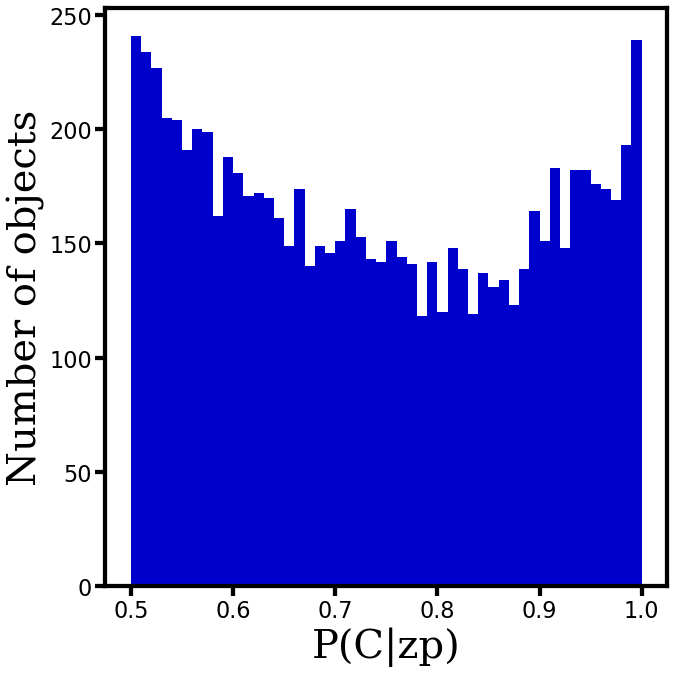

In [11]:
bins = 50
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(P_pz_C_array, bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0, range=[0.5, 1.0])
ax1.set_xlabel("P(C|zp)", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-real-clusters/P(C | P(zp))_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

In [34]:
cut_zp = 0.89

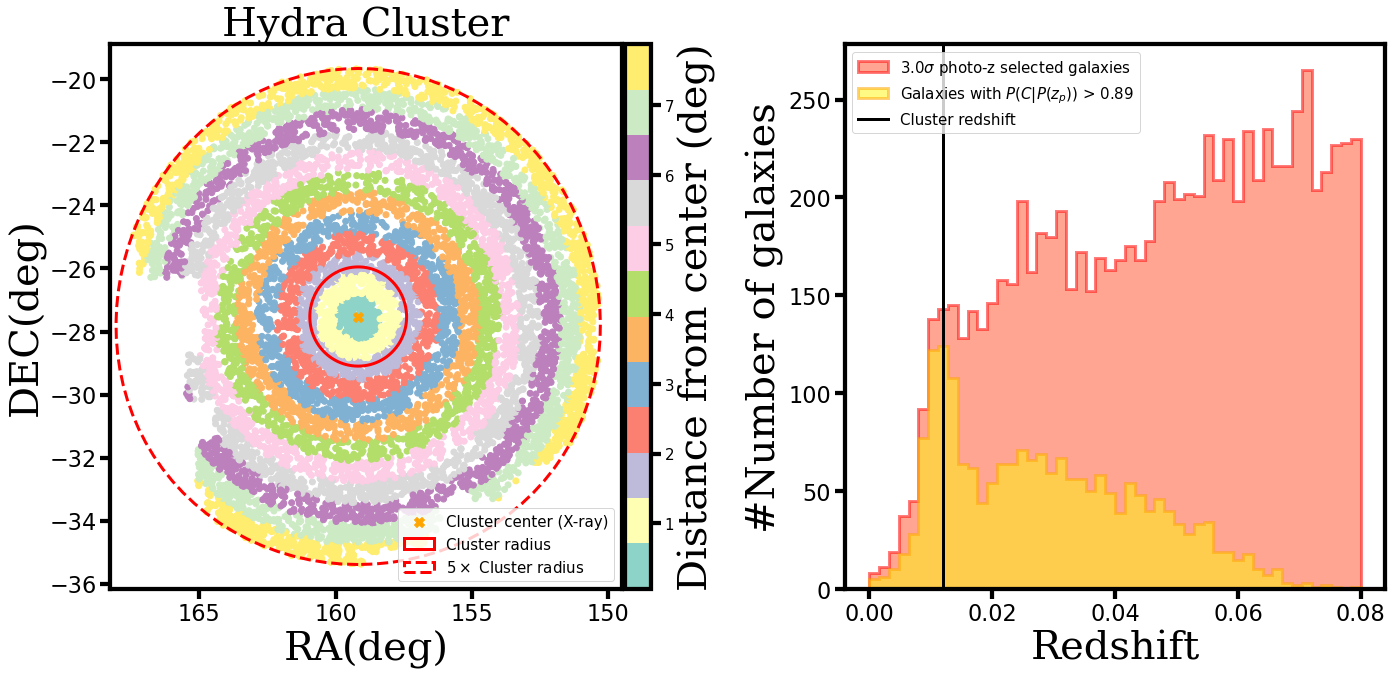

In [49]:
bins = 50
fig = plt.figure(figsize=(20, 18))

ax1 = fig.add_subplot(221)
sc1 = ax1.scatter(ra[mask_cluster], dec[mask_cluster], 
            marker='o', c=dist[mask_cluster], cmap=cm.Set3, rasterized=True)
ax1.scatter(cl_ra, cl_dec, marker="X", s=100, color="orange", label="Cluster center (X-ray)")
# ax1.scatter(ra0_optical, dec0_optical, marker="X", s=100, color="red", label="Cluster center (Optical)")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_name, fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=cl_ra, dec=cl_dec, frame='icrs', unit='deg')
r1 = SphericalCircle(c0, cl_radius_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*cl_radius_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)
ax1.legend(fontsize=15)


ax2 = fig.add_subplot(222)

ax2.hist(zp[mask_cluster], bins=bins, color=colors2[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"{}$\sigma$ photo-z selected galaxies".format(fz1), edgecolor="red", linewidth=3.0)

ax2.hist(zp[mask_cluster][P_pz_C_array > cut_zp], bins=bins, color=colors3[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"Galaxies with $P(C | P(z_p))$ > {:.2f}".format(cut_zp), edgecolor="orange", linewidth=3.0)

ax2.set_xlabel('Redshift',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(cl_z, color="black", lw=3, label="Cluster redshift")
ax2.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

### Comparing our selection with CHANCES'

In [102]:
t_specz = pd.read_csv("../../Masters/Pesquisa/CHANCES-target-selection/CHANCES-catalogues/final_catalogue_tables/Hydra-InSPLUS-AndLegacy-CHANCES_new_modified_SpecZ_20240124_crossmatch.csv", 
                usecols=['OBJECT_ID', 'RA_J2000', 'Dec_J2000', "z", "zp"])

In [103]:
objid_specz = np.array(t_specz["OBJECT_ID"])
z = np.array(t_specz["z"])
zp_specz = np.array(t_specz["zp"])

In [59]:
#Define a range of redshifts for the cluster
zlower = 0
zupper = 0.03

In [61]:
specz_members, specz_id_members = sigma_clipping(z, objid_specz, zlower, zupper, 3)

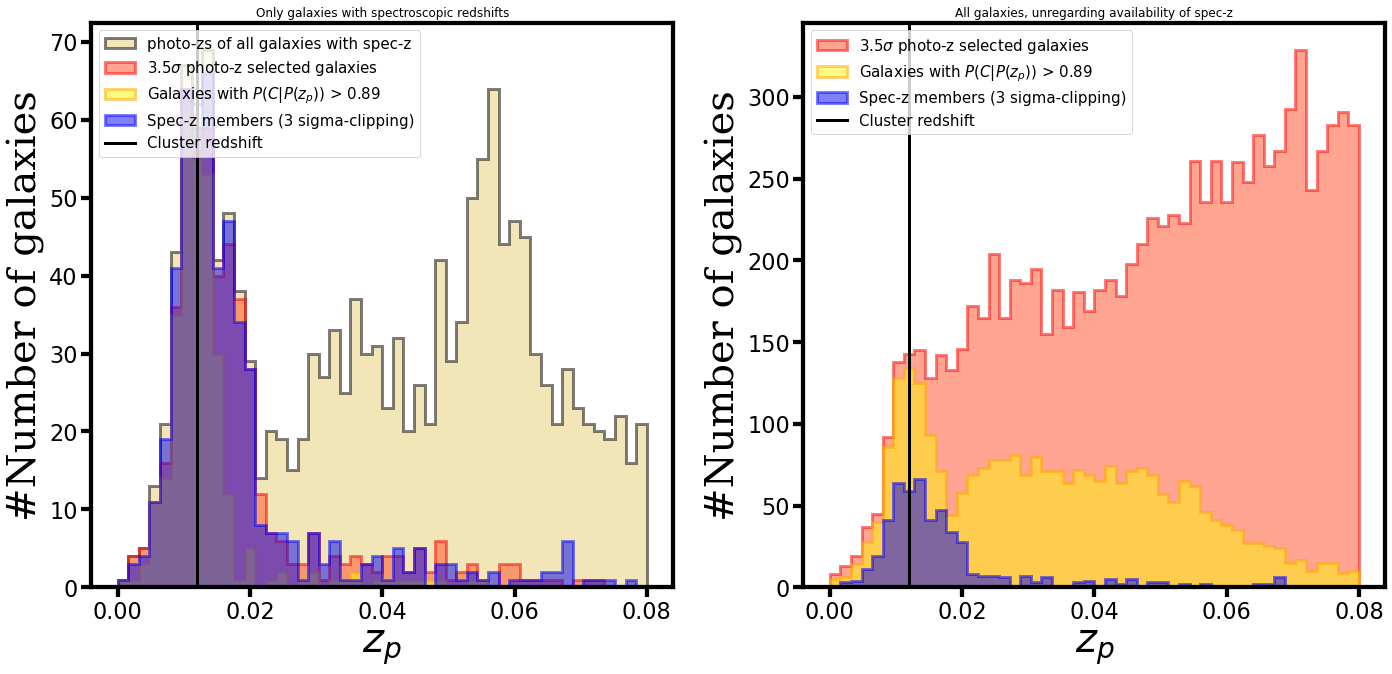

In [118]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(121)

ax1.hist(zp_specz, bins=bins, color=colors2[6], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"photo-zs of all galaxies with spec-z".format(cut_zp), edgecolor="black", linewidth=3.0)

ax1.hist(zp[mask_cluster & np.isin(objid, objid_specz)], bins=bins, color=colors2[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"{}$\sigma$ photo-z selected galaxies".format(fz1), edgecolor="red", linewidth=3.0)

ax1.hist(zp[mask_cluster][(P_pz_C_array > cut_zp) & np.isin(objid[mask_cluster], objid_specz)], bins=bins, color=colors3[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"Galaxies with $P(C | P(z_p))$ > {:.2f}".format(cut_zp), edgecolor="orange", linewidth=3.0)

ax1.hist(zp_specz[np.isin(objid_specz, specz_id_members)], bins=bins, color=colors1[0], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"Spec-z members (3 sigma-clipping)".format(cut_zp), edgecolor="blue", linewidth=3.0)

ax1.set_title("Only galaxies with spectroscopic redshifts")
ax1.set_xlabel(r'$z_p$',fontdict=font)
ax1.set_ylabel('#Number of galaxies',fontdict=font)
ax1.axvline(cl_z, color="black", lw=3, label="Cluster redshift")
ax1.legend(fontsize=15, loc=2)


ax2 = fig.add_subplot(122)
ax2.hist(zp[mask_cluster], bins=bins, color=colors2[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"{}$\sigma$ photo-z selected galaxies".format(fz1), edgecolor="red", linewidth=3.0)

ax2.hist(zp[mask_cluster][P_pz_C_array > cut_zp], bins=bins, color=colors3[8], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"Galaxies with $P(C | P(z_p))$ > {:.2f}".format(cut_zp), edgecolor="orange", linewidth=3.0)

ax2.hist(zp_specz[np.isin(objid_specz, specz_id_members)], bins=bins, color=colors1[0], histtype='stepfilled',
                 range=[0.0, 0.08], alpha=0.5, label=r"Spec-z members (3 sigma-clipping)".format(cut_zp), edgecolor="blue", linewidth=3.0)

ax2.set_title("All galaxies, unregarding availability of spec-z")
ax2.set_xlabel(r'$z_p$',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(cl_z, color="black", lw=3, label="Cluster redshift")
ax2.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

In [75]:
#CHANCES purity and completeness:
p_chances = np.sum(np.isin(specz_id_members, objid[mask_cluster])) / np.sum(np.isin(objid[mask_cluster], objid_specz))
c_chances = np.sum(np.isin(specz_id_members, objid[mask_cluster])) / len(specz_id_members)

print("Estimated purity for CHANCES selection method = {}".format(p_chances))
print("Estimated completeness for CHANCES selection method = {}".format(c_chances))

print("")

#My membership method purity and completeness:
p_mymethod = np.sum(np.isin(specz_id_members, objid[mask_cluster][P_pz_C_array > cut_zp])) / np.sum(np.isin(objid[mask_cluster][P_pz_C_array > cut_zp], objid_specz))
c_mymethod = np.sum(np.isin(specz_id_members, objid[mask_cluster][P_pz_C_array > cut_zp])) / len(specz_id_members)

print("Estimated purity for my method = {}".format(p_mymethod))
print("Estimated completeness for my method = {}".format(c_mymethod))

Estimated purity for CHANCES selection method = 0.8522954091816367
Estimated completeness for CHANCES selection method = 0.7907407407407407

Estimated purity for my method = 0.9139072847682119
Estimated completeness for my method = 0.5111111111111111
